In [1]:
# this enable automatic reloading of libraries
%load_ext autoreload
%autoreload 2

from clib.bellhop import *
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

1 grid file found, uses: /home/datawork-lops-osi/jgula/NESED/nesea_grd.nc
-- Grid object
dim lon_rho: 1602  2002
lon_rho min= -72.123, max=-58.273
lat_rho min= 34.123, max=43.734
h min= 20.000, max=5543.070
Uses the following output file: /home/datawork-lops-osi/jgula/NESED/nesed_avg.00260.nc
Uses the following time : 0


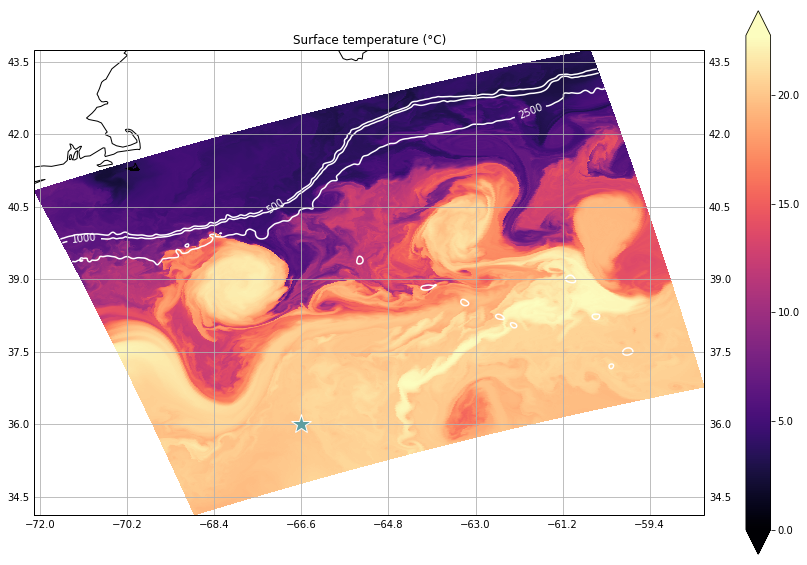

In [2]:
s = bellhop({'gs': {'datadir': '/home/datawork-lops-osi/jgula/NESED/', 'file':10, \
                    'itime':0,'lon':-66.6, 'lat':36., 'plot_map': True, \
                    'contour':True}}, zmax = 4900)

In [3]:
Arr, Pos = s.read_arrivals_asc ('files_C4/4_time0.arr', Narrmx = 526)

Max.number of arrivals for source index 0 is 525


In [4]:
Nsd = np.shape(Pos['s']['depth'])[0]
Nrd = np.shape(Pos['r']['depth'])[0]
Nrr = np.shape(Pos['r']['range'])[0]

print('Number of source depths   : Nsd = ', Nsd)
print('Number of receiver depths : Nrd = ', Nrd)
print('Number of receiver ranges : Nrr = ', Nrr)

print ('\nTotal number of receivers : ', Nrr*Nrd)

Number of source depths   : Nsd =  1
Number of receiver depths : Nrd =  51
Number of receiver ranges : Nrr =  101

Total number of receivers :  5151


In [5]:
### sonar equation
SL = 185                 # Souce level (dB)
NL = 81.7                # Noise level (dB)
DI = 0                   # Directivity index (dB)
B = 200                  # bandwidth (Hz)
T = 1                    # transmitted signal duration (s)
PG = 10.0*np.log10(B*T)  # Processing gain (dB)

#RT  = SL - TL - NL + DI + PG 
seuil_d = 10.

In [6]:
# Create time table from bellhop output data. Based on detection treshold method.
def time_table (Arr) :
    T = np.zeros( (Nrr, Nrd, Nsd) )
    for isd1 in range (Nsd):
        for ird1 in range (Nrd) : 
            for irr1 in range (Nrr) :
                Narr = int(Arr['Narr'][irr1, ird1, isd1])
                if not Narr ==0 :
                    A = abs(Arr['A'][irr1, :Narr, ird1, isd1])  # amplitude 
                    TL = - 20.0*np.log10(A)
                    RL = SL - TL - NL +DI + PG    # received level 
                    t = Arr['delay'][irr1, :Narr, ird1, isd1]
                    t_ok = t[np.where(RL > seuil_d)]

                    if len(t_ok > 0): 
                        t_min = np.min(t_ok)
                        T[irr1,ird1,isd1] = t_min  
                    else : 
                        T[irr1,ird1,isd1] = np.NaN
                else : 
                    T[irr1,ird1,isd1] = np.NaN
    return (T)

In [7]:
T_true = time_table(Arr)

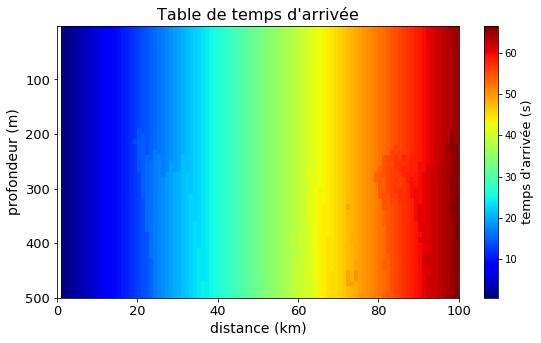

In [10]:
isd = 0    # source number (only 1 source here)
R = np.array(Pos['r']['range'])
Z = np.array(Pos['r']['depth'])
plt.figure(figsize=(9,5))
plt.pcolormesh(R/1000., Z, T_true[:,:,isd].T, cmap='jet')
plt.title ("Table de temps d'arrivée", fontsize=16)
plt.xlabel("distance (km)", fontsize=14)
plt.ylabel("profondeur (m)", fontsize=14)
cbar = plt.colorbar()
cbar.set_label("temps d'arrivée (s)", fontsize=13)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.gca().invert_yaxis()

plt.savefig('time_table', dpi=100)

---
----
---
---
# Différence de temps d'arrivée entre step = auto (500m) et 10m 

In [9]:
Arr_t, Pos_t = s.read_arrivals_asc ('files_C4/test1.arr', Narrmx = 522)

Max.number of arrivals for source index 0 is 521


In [10]:
T_test= time_table(Arr_t)

In [11]:
diff = T_true - T_test
celerity = 1500. 
dx = diff * celerity

In [16]:
isd = 0    # source number (only 1 source here)
R = np.array(Pos['r']['range'])
Z = np.array(Pos['r']['depth'])

dt < 2ms : 79.4%
2ms < dt < 10ms : 14.7%
dt > 10ms : 4.9%


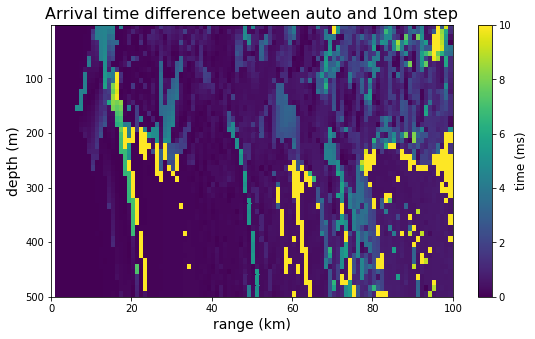

In [26]:
# dx table
plt.figure(figsize=(9,5))
plt.pcolormesh(R/1000., Z, (abs(diff[:,:,isd]).T)*1000.) #, cmap='jet')
plt.title ('Arrival time difference between auto and 10m step', fontsize=16)
plt.xlabel("range (km)", fontsize=14)
plt.ylabel("depth (m)", fontsize=14)
cbar = plt.colorbar()
cbar.set_label("time (ms)", fontsize=12)
plt.clim([0,10])
plt.gca().invert_yaxis()

# Pourcents
tot = diff.shape[0]*diff.shape[1]
under10 = np.where(abs(diff) <0.002)[0].shape[0]
under50 = np.where(np.logical_and(abs(diff) >=0.002, abs(diff) < 0.01))[0].shape[0]
over50  = np.where(abs(diff) >= 0.01)[0].shape[0]
print ('dt < 2ms : %.1f' %(under10/tot*100.) + '%')
print ('2ms < dt < 10ms : %.1f' %(under50/tot*100.) + '%')
print ('dt > 10ms : %.1f' %(over50/tot*100.) + '%')


plt.savefig('diff_step', dpi=100)

In [24]:
AA = abs(diff[:,:,isd])
np.max(AA[~np.isnan(AA)])

1.8239479000000003

---
---
# Différence de temps d'arrivée entre step = 10m et 1m 

In [31]:
Arr_t0, Pos_t0 = s.read_arrivals_asc ('files_C4/test0.arr', Narrmx = 522)

Max.number of arrivals for source index 0 is 522


In [32]:
T_test0= time_table(Arr_t0)
diff0 = T_test - T_test0

dt < 2ms : 94.0%
2ms < dt < 10ms : 2.6%
dt > 10ms : 0.6%


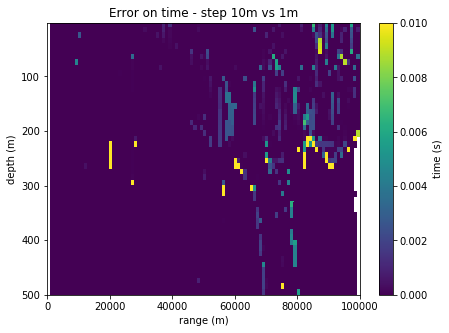

In [33]:
# dx table
plt.figure(figsize=(7,5))
plt.pcolormesh(R, Z, abs(diff0[:,:,isd]).T) #, cmap='jet')
plt.title ('Error on time - step 10m vs 1m')
plt.xlabel("range (m)")
plt.ylabel("depth (m)")
cbar = plt.colorbar()
cbar.set_label("time (s)")
plt.clim([0,0.01])
plt.gca().invert_yaxis()

# Pourcents
tot = diff0.shape[0]*diff0.shape[1]
under10 = np.where(abs(diff0) <0.002)[0].shape[0]
under50 = np.where(np.logical_and(abs(diff0) >=0.002, abs(diff0) < 0.01))[0].shape[0]
over50  = np.where(abs(diff0) >= 0.01)[0].shape[0]
print ('dt < 2ms : %.1f' %(under10/tot*100.) + '%')
print ('2ms < dt < 10ms : %.1f' %(under50/tot*100.) + '%')
print ('dt > 10ms : %.1f' %(over50/tot*100.) + '%')


plt.savefig('diff_10m_1m', dpi=100)